In [1]:
#! pip install nibabel -U

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

import surface_distance_based_measures

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
task_number = "05"
task_name = "prostate".lower()
path = "./Task%s_%s/3d_fullres" % (task_number, task_name.capitalize())
file_prefix = task_name

run_data = [
    "A100/22972351",
    "A100/23011851",
    "A100/23012378",
]

validation_raw_numbers = [
    "00",
    "04",
    "14",
    "20",
    "25",
    "31",
    "42",
]

results = []

In [5]:
# Calculate DSC: Dice Similarity Coefficient; NSD: Normalized Surface Distance
for run in run_data:

    run_info = {}
    run_info[run] = {}

    for validation_raw_number in validation_raw_numbers:

        run_info[run][validation_raw_number] = {}

        # Ground Truth
        mask_gt_img = nib.load(
            "./Task%s_%s/ground_truth/labelsTr/%s_%s.nii.gz"
            % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
        )
        mask_gt = np.array(mask_gt_img.dataobj)

        # Run data
        mask_pred_img = nib.load(
            "%s/%s/results/fold_0/validation_raw_postprocessed/%s_%s.nii.gz"
            % (path, run, file_prefix, validation_raw_number)
        )
        mask_pred = np.array(mask_pred_img.dataobj)

        # Calculate Dice Score
        run_info[run][validation_raw_number][
            "dice_similarity_coefficient"
        ] = surface_distance_based_measures.compute_dice_coefficient(mask_gt, mask_pred)

        # Calculate Normalized Surface Distance
        spacing_mm = (3, 2, 1)
        surface_distances = surface_distance_based_measures.compute_surface_distances(
            mask_gt, mask_pred, spacing_mm
        )
        run_info[run][validation_raw_number][
            "normalized_surface_distance"
        ] = surface_distance_based_measures.compute_surface_dice_at_tolerance(
            surface_distances, 1
        )

    results.append(run_info)

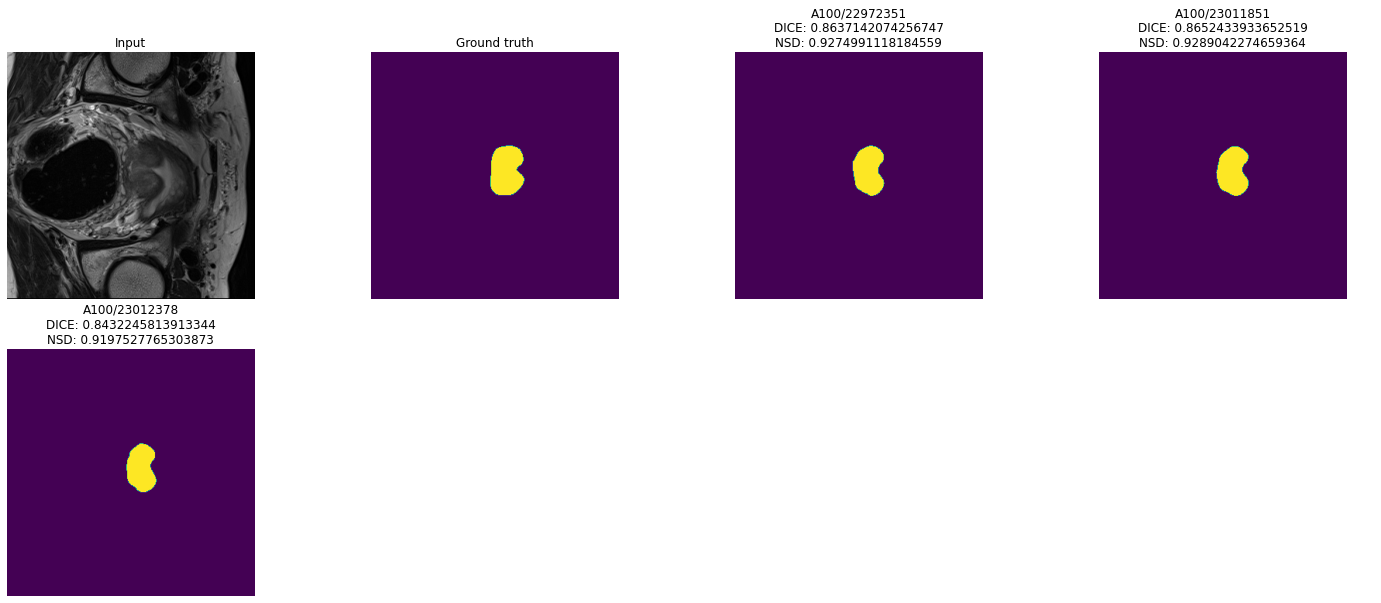

In [6]:
validation_raw_number = "00"
display_layer = 11

# Calculate the number of rows based on the size of results + 2 (input & ground truth)
# and the value of n_cols
n_cols = 4
n_rows = int(np.ceil((len(results) + 2) / n_cols))

# Define the number of rows and columns and set the graph size
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, n_rows * 5))

# Hide the graph axes
for ax in axes.flatten():
    ax.axis("off")

# Display the input image as the first image
axes[0, 0].imshow(
    nib.load(
        "./Task%s_%s/ground_truth/imagesTr/%s_%s.nii.gz"
        % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
    ).get_fdata()[:, :, display_layer, 0],
    cmap="gray",
)
axes[0, 0].set_title("Input")

# Display the ground truth as the second image
axes[0, 1].imshow(
    nib.load(
        "./Task%s_%s/ground_truth/labelsTr/%s_%s.nii.gz"
        % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
    ).get_fdata()[:, :, display_layer]
)
axes[0, 1].set_title("Ground truth")


for i, result in enumerate(results):

    # The first key should the run name (ie A100/12345678)
    run = list(result.keys())[0]

    image_path = (
        "%s/%s/results/fold_0/validation_raw_postprocessed/%s_%s.nii.gz"
        % (path, run, file_prefix, validation_raw_number)
    )

    # Use i + 2 instead of i because of the input image and the ground truth always being the first 2 images

    # Calculate the row number by dividing the list item number by the number of columns and rounding down
    row = int(np.floor((i + 2) / n_cols))
    # Calculate the column number by finding the remainder of the list item number divided by the number of columns
    column = int(np.remainder((i + 2), n_cols))

    # Display the display_layer layer of the image
    axes[row, column].imshow(nib.load(image_path).get_fdata()[:, :, display_layer])
    axes[row, column].set_title(
        "%s\nDICE: %s\nNSD: %s"
        % (
            run,
            result[run][validation_raw_number]["dice_similarity_coefficient"],
            result[run][validation_raw_number]["normalized_surface_distance"],
        )
    )

### Create a dataframe with just the dice scores

In [7]:
dice_scores = pd.DataFrame(index=validation_raw_numbers, columns=run_data)

for result in results:

    run = list(result.keys())[0]

    for validation_raw_number in list(result[run].keys()):
        dice_scores[run][validation_raw_number] = result[run][validation_raw_number][
            "dice_similarity_coefficient"
        ]

dice_scores.head()

,A100/22972351,A100/23011851,A100/23012378
00,0.863714,0.865243,0.843225
04,0.872243,0.874339,0.872813
14,0.853513,0.852449,0.845371
20,0.907363,0.906631,0.903007
25,0.893184,0.894464,0.89711


### Create a new column with the dice score range

In [8]:
dice_scores["range"] = dice_scores.max(axis=1) - dice_scores.min(axis=1)

### Sort the dataframe by the dice score "range" column

In [9]:
dice_scores.sort_values(by=["range"], ascending=False).head()

,A100/22972351,A100/23011851,A100/23012378,range
00,0.863714,0.865243,0.843225,0.022019
14,0.853513,0.852449,0.845371,0.008142
31,0.858654,0.86024,0.855552,0.004688
20,0.907363,0.906631,0.903007,0.004356
25,0.893184,0.894464,0.89711,0.003926
